In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import shap

In [20]:
lgb.__version__, xgb.__version__

('2.1.2', '0.7')

In [21]:
# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
X,y = shap.datasets.boston()

In [3]:
xgb_model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(X, label=y), 100)

In [32]:
fe_imp_df = pd.DataFrame.from_dict(xgb_model.get_fscore(), orient='index', columns=['importance']).reset_index().rename(columns={'index':'feature'}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [33]:
fe_imp_df

,feature,importance
0,CRIM,333
1,RM,331
2,LSTAT,294
3,DIS,197
4,NOX,174
5,PTRATIO,81
6,B,59
7,TAX,55
8,INDUS,52
9,AGE,50


In [30]:
X.shape

(506, 13)

In [31]:
lgb_train = lgb.Dataset(X.head(406), label=y[:406])
lgb_val = lgb.Dataset(X.tail(100), label=y[-100:])

model = lgb.train({'learning_rate': 0.01, 'metric': 'l1'}, lgb_train, valid_sets=lgb_val, early_stopping_rounds=5, verbose_eval=10)

Training until validation scores don't improve for 5 rounds.
[10]	valid_0's l1: 7.49462
[20]	valid_0's l1: 6.83969
[30]	valid_0's l1: 6.31596
[40]	valid_0's l1: 5.93767
[50]	valid_0's l1: 5.596
[60]	valid_0's l1: 5.301
[70]	valid_0's l1: 4.98295
[80]	valid_0's l1: 4.72326
[90]	valid_0's l1: 4.49777
[100]	valid_0's l1: 4.3644
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 4.3644


In [37]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [33]:
explainer.expected_value

24.089901523471887

In [35]:
np.mean(y[:406])  # train target mean

24.089901477832512

In [34]:
np.mean(y[-100:])  # val target mean

16.211

In [28]:
X.shape

(506, 13)

In [27]:
np.mean(y)

22.532806324110677

In [38]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [6]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

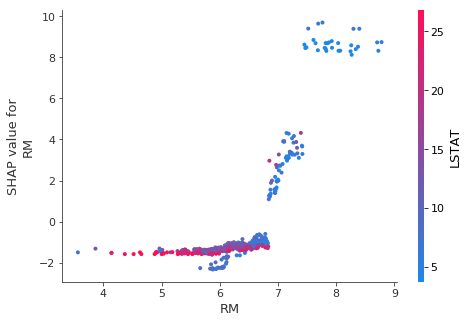

In [7]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("RM", shap_values, X)

In [4]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


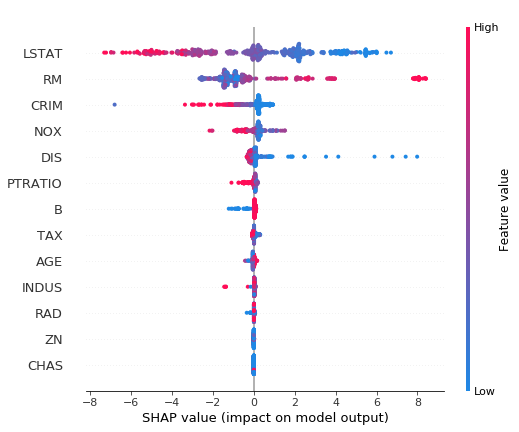

In [5]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

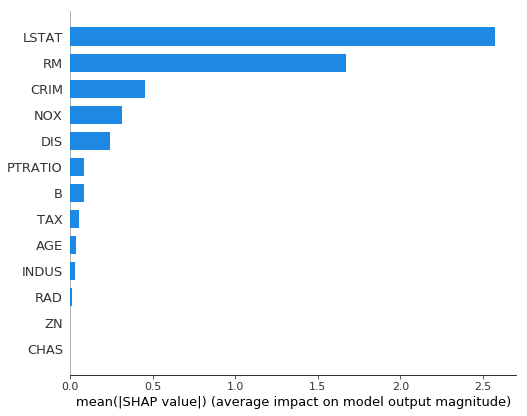

In [6]:
shap.summary_plot(shap_values, X, plot_type="bar")

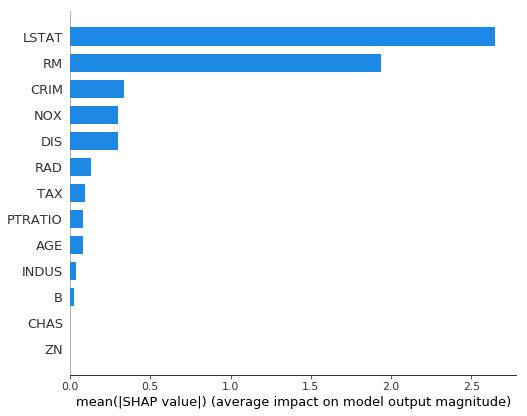

In [8]:
shap.summary_plot(shap_values, X, plot_type="bar")

/home/kai/anaconda3/envs/tf_newer/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'13 Features. (gain)')

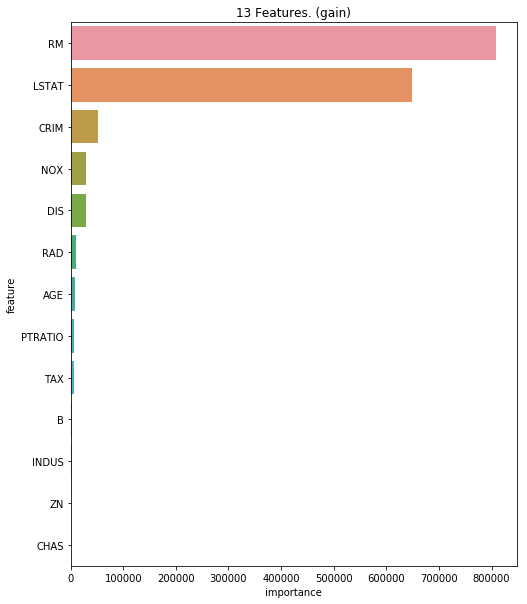

In [15]:
fold_importance_gain_df = pd.DataFrame()
fold_importance_gain_df["feature"] = model.feature_name()
fold_importance_gain_df["importance"] = model.feature_importance(importance_type='gain')
fold_importance_gain_df["fold"] = 0#n_fold + 1
fold_importance_gain_df = fold_importance_gain_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=fold_importance_gain_df.head(40))
plt.title('{} Features. (gain)'.format(len(model.feature_name())))
# plt.tight_layout()
# plt.savefig('fe_imp_gain.png')

/home/kai/anaconda3/envs/tf_newer/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


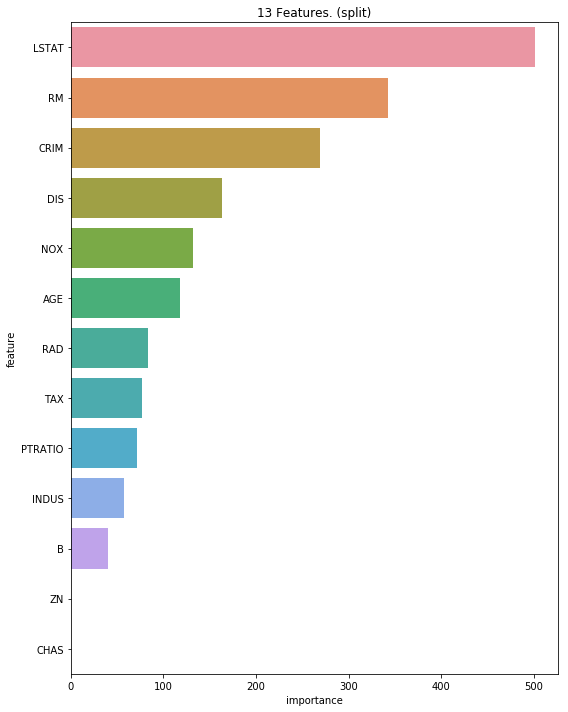

In [16]:
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = model.feature_name()
fold_importance_df["importance"] = model.feature_importance(importance_type='split')
fold_importance_df["fold"] = 0#n_fold + 1
fold_importance_df = fold_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=fold_importance_df.head(40))
plt.title('{} Features. (split)'.format(len(model.feature_name())))
plt.tight_layout()
# plt.savefig('fe_imp.png')